# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [173]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Graph color
color_map = plt.cm.get_cmap('Blues')
blue = color_map.reversed()

# Data Cleaning
---

In [2]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
def id_mapper(df,id_column):
    '''
    Converts long string of customer id's and promotion id's to a simple integer
    
    df: Dataframe with the id string
    id_column: column of df dataframe with the id
    returns: Returns dictionary of coded id to integer
    '''
    coded_dict = dict()
    cter = 1
    
    for val in df[id_column]:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1

        
    return coded_dict


def clean_portfolio(portfolio):
    '''
    Perform data cleaning of portfolio dataframe by performing hot encoding of promotion channel and offer type.
    Takes channels columns and pivot to its own individual columns
    
    portfolio: portfolio dataframe
    Returns: clean porfolio dataframe
    
    '''
    # make copy of dataframe
    clean_portfolio = portfolio.copy()
    
    user_dict = id_mapper(clean_portfolio,'id')
    clean_portfolio['id'] = clean_portfolio['id'].apply(lambda x: user_dict[x])  
    
    # apply one hot encoding to channels column
    clean_portfolio['email'] = clean_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    clean_portfolio['mobile'] = clean_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    clean_portfolio['social'] = clean_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    clean_portfolio['web'] = clean_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    
    # apply one hot encoding to offer_type column
    offer_type = pd.get_dummies(clean_portfolio['offer_type'])
    
    # combine the portfolio and offer_type dataframe to form a cleaned dataframe
    clean_portfolio = pd.concat([clean_portfolio, offer_type], axis=1, sort=False)
    
    #rename id as offer_id
    clean_portfolio.rename(columns={'id': 'offer_id'}, inplace=True)
    
    # drop channel, offer_type, and drop email because all of email column is '1'
    clean_portfolio.drop(['channels', 'offer_type', 'email'], axis=1, inplace=True)
    
    clean_portfolio = clean_portfolio[['offer_id', 'difficulty', 'duration', 'reward', 'mobile',
       'social', 'web', 'bogo', 'discount', 'informational']]
    
    return clean_portfolio

clean_portfolio = clean_portfolio(portfolio)

In [4]:
clean_portfolio

,offer_id,difficulty,duration,reward,mobile,social,web,bogo,discount,informational
0,1,10,7,10,1,1,0,1,0,0
1,2,10,5,10,1,1,1,1,0,0
2,3,0,4,0,1,0,1,0,0,1
3,4,5,7,5,1,0,1,1,0,0
4,5,20,10,5,0,0,1,0,1,0
5,6,7,7,3,1,1,1,0,1,0
6,7,10,10,2,1,1,1,0,1,0
7,8,0,3,0,1,1,0,0,0,1
8,9,5,5,5,1,1,1,1,0,0
9,10,10,7,2,1,0,1,0,1,0


In [5]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [6]:
profile.shape

(17000, 5)

In [7]:
def clean_profile(profile):
    '''
    Takes profile dataframe, rename columns, converts customer id code and converts to a corresponding customer id as
    an integer. Converts member date to length of membership. Filter all age 118 as NaN. Drop all NaN. 
    
    profile: dataframe of customer profile
    returns: Clean profile dataframe and member id dictionary
    
    '''
    clean_profile = profile.copy()
    
    #rename column name
    clean_profile.rename(columns={'id': 'customer_id', 'became_member_on': 'member_since'}, inplace=True)
    user_dict = id_mapper(clean_profile,'customer_id')
    clean_profile['customer_id'] = clean_profile['customer_id'].apply(lambda x: user_dict[x])
    
    #convert member_since to datetime datatype and calculate number of years they have became members
    clean_profile['member_since'] = pd.to_datetime(clean_profile['member_since'], format='%Y%m%d').dt.date
    clean_profile['member_length'] = (datetime.datetime.today().date() - clean_profile['member_since']) / np.timedelta64(1,'Y')
    clean_profile['member_length'] = clean_profile['member_length'].round(0).astype(int)
    
    # convert age 118 as NaN
    clean_profile['age'] = clean_profile['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # drop all missing values
    clean_profile.dropna(inplace=True)
    
    clean_profile = clean_profile[['customer_id', 'age', 'member_since', 'gender',  'income',
       'member_length']]
    
    return clean_profile, user_dict

clean_profile, user_dict = clean_profile(profile)

In [8]:
clean_profile.head()

,customer_id,age,member_since,gender,income,member_length
1,2,55.0,2017-07-15,F,112000.0,3
3,4,75.0,2017-05-09,F,100000.0,3
5,6,68.0,2018-04-26,M,70000.0,2
8,9,65.0,2018-02-09,M,53000.0,2
12,13,58.0,2017-11-11,M,51000.0,3


In [9]:
def clean_transcript(transcript):
    """
    Takes transcript of transaction, rename person as customer_id, convert coded customer_id as integer from dictionary.
    
    transcript: Transcript dataframe of transaction
    returns: clean transcript database
    """
    
    clean_transcript = transcript.copy()
    
    # mapping person's id with the dictionary which we made before
    clean_transcript.rename(columns={'person': 'customer_id'}, inplace=True)
    clean_transcript['customer_id'] = clean_transcript['customer_id'].apply(lambda x: user_dict[x])
    clean_transcript = clean_transcript[['customer_id', 'event', 'time', 'value']]
    
    return clean_transcript

clean_transcript = clean_transcript(transcript)

In [10]:
def offer(clean_transcript):
    """
    Takes clean_transcript database and filter offer related transaction
    
    clean_transcript: Clean transcript dataframe
    returns: offer transcript dataframe
    """
    offer = clean_transcript.copy()
    
    # Filter out non transaction
    offer = offer[offer['event'] != 'transaction']
    
    # Convert coded offer_id to assigned integer
    offer['offer_id'] = offer['value'].apply(lambda x:list(x.values())[0])
    
    # Pull reward amount from value column
    offer['reward_amount'] = offer['value'].apply(lambda x: list(x.values())[1] if len(x.values())>1 else 0)
    
    # Convert coded offer_id to assigned integer
    offer_dict = id_mapper(offer, 'offer_id')
    offer['offer_id'] = offer['offer_id'].apply(lambda x: offer_dict[x])
    offer = offer.drop(['value'], axis=1)
    
    # Merge dataframes
    offer = offer.merge(clean_profile, on='customer_id')
    offer = offer.merge(clean_portfolio, on='offer_id')
    
    return offer

offer = offer(clean_transcript)


def transaction(clean_transcript):
    """
    Takes clean_transcript dataframe and filter all transaction. Takes the value out and place in column.
    
    clean_transcript: clean transcript dataframe
    returns: transaction dataframe
    """
    transaction = clean_transcript.copy()
    
    # filter out transactions
    transaction = clean_transcript[clean_transcript['event'] == 'transaction']
    
    # pull transaction amount from value column
    transaction['trans_amt'] = transaction['value'].apply(lambda x: list(x.values())[0])
    transaction = transaction.drop(['value'], axis=1)
    
    # merge dataframe
    transaction = transaction.merge(clean_profile, on='customer_id')
    
    return transaction

transaction = transaction(clean_transcript)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#  Analysis
---

In [11]:
profile.shape

(17000, 5)

In [12]:
clean_profile.shape

(14825, 6)

In [13]:
clean_portfolio

,offer_id,difficulty,duration,reward,mobile,social,web,bogo,discount,informational
0,1,10,7,10,1,1,0,1,0,0
1,2,10,5,10,1,1,1,1,0,0
2,3,0,4,0,1,0,1,0,0,1
3,4,5,7,5,1,0,1,1,0,0
4,5,20,10,5,0,0,1,0,1,0
5,6,7,7,3,1,1,1,0,1,0
6,7,10,10,2,1,1,1,0,1,0
7,8,0,3,0,1,1,0,0,0,1
8,9,5,5,5,1,1,1,1,0,0
9,10,10,7,2,1,0,1,0,1,0


In [14]:
transcript.shape

(306534, 4)

In [15]:
offer.shape

(148805, 19)

In [16]:
transaction.shape

(123957, 9)

In [17]:
# Duration of experiment
offer.time.max() / 24

29.75

### Plots
---

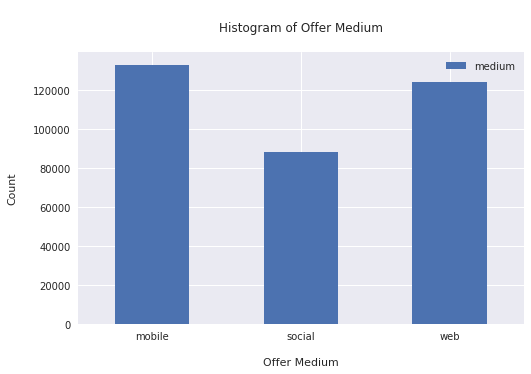

In [18]:
# Create Histogram of Offer medium
sns.set(style="darkgrid")
df = offer[['mobile', 'social', 'web']]
df = pd.DataFrame(df.sum())
medium = list(df.index)
values = [132573,87993,124289]

df = pd.DataFrame({'medium': values},
                    index=medium)
ax = df.plot.bar(rot=0, figsize=(8,5), title='\nHistogram of Offer Medium\n')
ax.set(xlabel='\nOffer Medium', ylabel='Count\n');

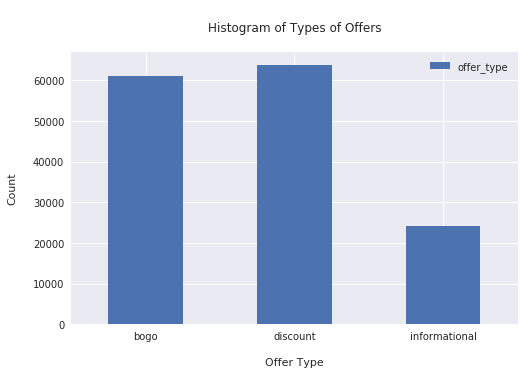

In [19]:
# Create Histogram of types of offers
df2 = offer[['bogo', 'discount', 'informational']]
df2 = df2.sum()
df2 = pd.DataFrame(df2)
offer_type = list(df2.index)
values = [61002, 63657, 24146]

df2 = pd.DataFrame({'offer_type': values},
                    index=offer_type)
ax = df2.plot.bar(rot=0, figsize=(8,5), title='\nHistogram of Types of Offers\n')
ax.set(xlabel='\nOffer Type', ylabel='Count\n');

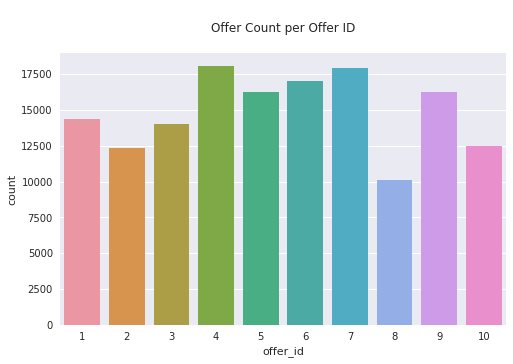

In [182]:
# Create Histogram of each Offer
sns.set(style="darkgrid")
plt.figure(figsize=(8,5))
sns.countplot(x=offer['offer_id'], data=offer).set_title('\nOffer Count per Offer ID\n');

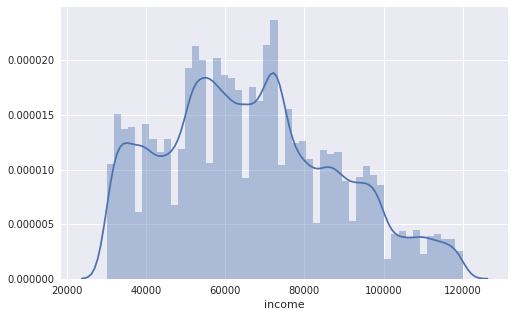

In [21]:
sns.set(style="darkgrid")
plt.figure(figsize=(8,5))
sns.distplot(offer.income);

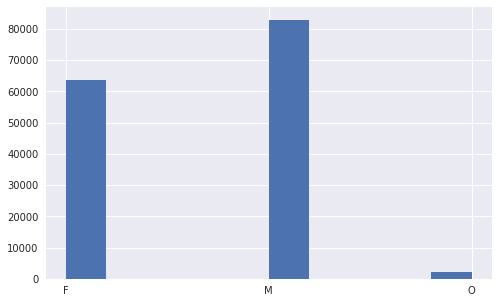

In [22]:
plt.figure(figsize=(8,5))
offer.gender.hist();

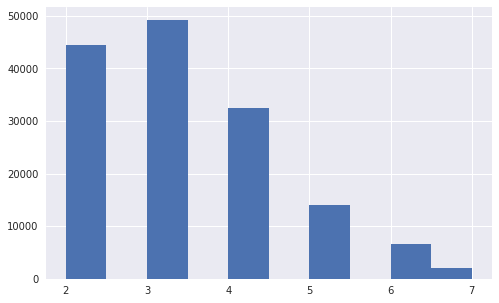

In [23]:
plt.figure(figsize=(8,5))
offer.member_length.hist();

## Infomation of data

- Experiment ran for 30 days
- 10 Different Offer types
- 4 Different offer medium
    - email, mobile, social, web
- 3 different offers
    - bogo, discount, informational
- 17000 customer
    - 14825 customers with profile information
- 306534 transcript events
    - 148805 offer events
    - 123957 transaction events

## Customer Profile: Questions
---

- Create a Profile of Customers and spending habits
- What Gender spends the most?
- What Income group spends the most?
- Who makes the most transaction?
- What is the breakdown of the different groups?
- Make Recommendation

Percentage more in Spending
Female over Male: 0.5069078757243515, Other over Male: 0.2750272006157769
[11.60660026925296, 17.490077356121663, 14.798731049971924]



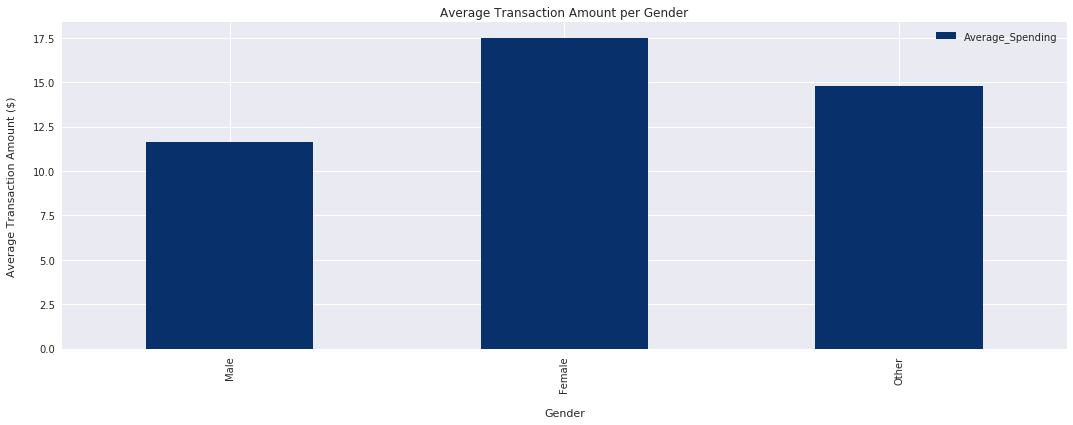

In [180]:
# Create Histogram of Average Transaction amount per Gender
F = transaction[transaction['gender'] == 'F'].trans_amt.sum() / transaction[transaction['gender'] == 'F'].shape[0]
M = transaction[transaction['gender'] == 'M'].trans_amt.sum() / transaction[transaction['gender'] == 'M'].shape[0]
O = transaction[transaction['gender'] == 'O'].trans_amt.sum() / transaction[transaction['gender'] == 'O'].shape[0]
gender = ['Male', 'Female', 'Other']
values = [M, F, O]
genders = pd.DataFrame(list(zip(gender, values)), 
               columns =['Gender', 'Average_Spending'], index=gender) 
ax = genders.plot(x='Gender', y='Average_Spending', figsize=(18,6), kind='bar', cmap=blue, title='Average Transaction Amount per Gender')
ax.set_xlabel('\nGender')
ax.set_ylabel('Average Transaction Amount ($)\n');
print("Percentage more in Spending\nFemale over Male: {}, Other over Male: {}".format(((F-M)/M), ((O-M)/M)))
print(values)
print()

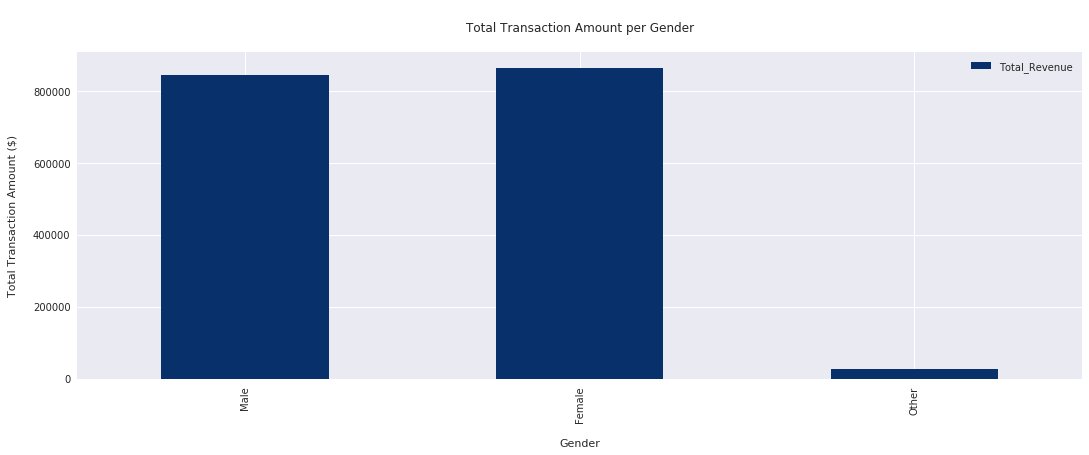

In [179]:
# Create Histogram of Total Transaction amount per Gender
F = transaction[transaction['gender'] == 'F'].trans_amt.sum()
M = transaction[transaction['gender'] == 'M'].trans_amt.sum()
O = transaction[transaction['gender'] == 'O'].trans_amt.sum()
gender = ['Male', 'Female', 'Other']
values = [M, F, O]
genders = pd.DataFrame(list(zip(gender, values)), 
               columns =['Gender', 'Total_Revenue'], index=gender) 
ax = genders.plot(x='Gender', y='Total_Revenue', cmap=blue, figsize=(18,6), kind='bar', title='\nTotal Transaction Amount per Gender\n')
ax.set_xlabel('\nGender')
ax.set_ylabel('Total Transaction Amount ($)\n');

[72794, 49382, 1781]

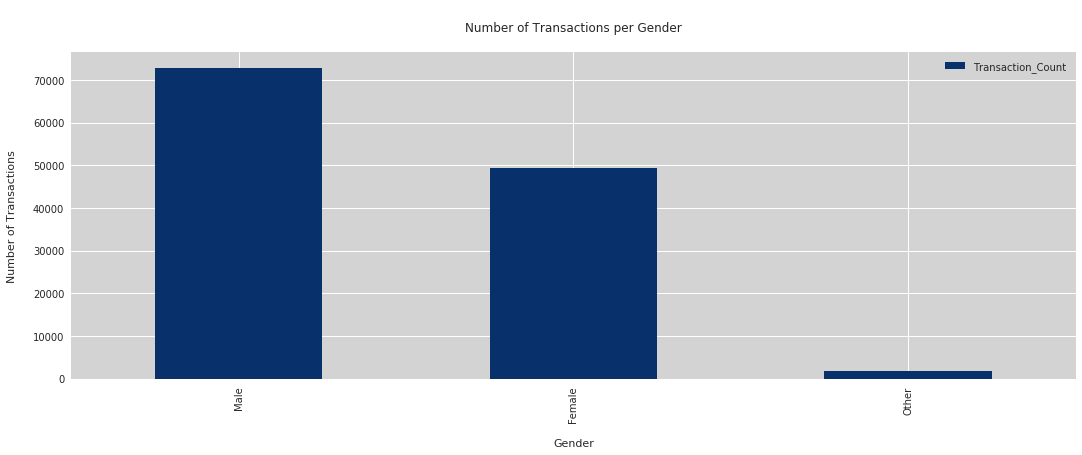

In [178]:
# Create Histogram of Number of Transaction per Gender
F = transaction[transaction['gender'] == 'F']['trans_amt'].count()
M = transaction[transaction['gender'] == 'M']['trans_amt'].count()
O = transaction[transaction['gender'] == 'O']['trans_amt'].count()
gender = ['Male', 'Female', 'Other']
values = [M, F, O]
genders = pd.DataFrame(list(zip(gender, values)), 
               columns =['Gender', 'Transaction_Count'], index=gender) 
ax = genders.plot(x='Gender', y='Transaction_Count', figsize=(18,6), cmap=blue, kind='bar', title='\nNumber of Transactions per Gender\n')
ax.set_xlabel('\nGender')
ax.set_ylabel('Number of Transactions\n');
ax.set_facecolor('lightgray')
values

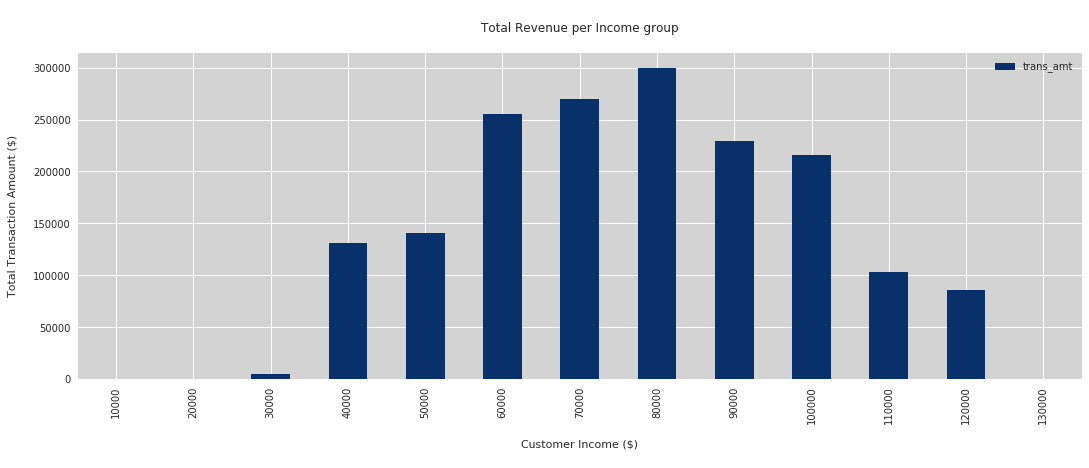

In [177]:
# Create Histogram of Total Transaction amount per Income group
trans_bin = transaction.copy()
trans_bin['income_bin'] = pd.cut(trans_bin['income'], [*range(0, 140000, 10000)], labels=[*range(10000, 140000, 10000)])
income_bin = trans_bin.groupby('income_bin')['trans_amt'].sum()
income_bin = pd.DataFrame({'income_bin':income_bin.index, 'trans_amt':income_bin.values})
sns.set(style="darkgrid")
ax = income_bin.plot(x='income_bin', y='trans_amt', cmap=blue, figsize=(18,6), kind='bar', title='\nTotal Revenue per Income group\n')
ax.set_xlabel('\nCustomer Income ($)\n')
ax.set_ylabel('Total Transaction Amount ($)\n');
ax.set_facecolor('lightgray')

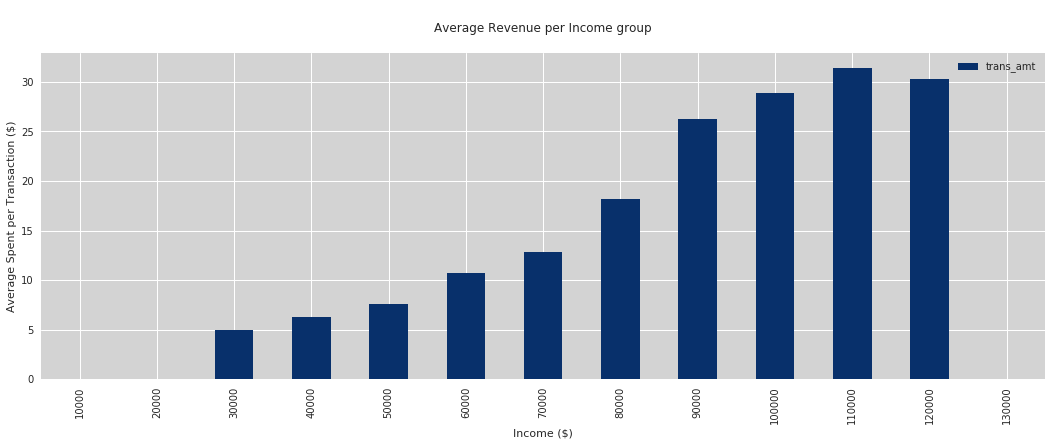

In [176]:
# Create Histogram of Average Income per Income group
trans_bin = transaction.copy()
trans_bin['income_bin'] = pd.cut(trans_bin['income'], [*range(0, 140000, 10000)], labels=[*range(10000, 140000, 10000)])
income_bin = trans_bin.groupby('income_bin')['trans_amt'].mean()
income_bin = pd.DataFrame({'income_bin':income_bin.index, 'trans_amt':income_bin.values})
sns.set(style="darkgrid")
ax = income_bin.plot(x='income_bin', y='trans_amt', figsize=(18,6), cmap=blue, kind='bar', title='\nAverage Revenue per Income group\n')
ax.set_xlabel('Income ($)')
ax.set_ylabel('Average Spent per Transaction ($)');
ax.set_facecolor("lightgray");

# Customer Profile: Answers

- Females spends the most per transaction, spending an average of $\$$17.50, while males spend less than $\$$12.
- Females spends about 50\% more than males and Others spend 25\% more
- For Revenues, Males and Females are roughly the same. This is due to having more Male customers and them making more transactions. Males make about 50\% more transaction than females.
- The middle income are the ones that send the most in terms of total spent at Starbucks ($\$60k - $\$80k), but the upper class spends more per transaction.

## Recommendations
- The two target groups are females and upper income groups. They spend more per visit but they visit less than the other groups. If we could get them to visit more, the revenues will increase.
- The largest customer group are middle income males, but they send less per visit. Suggest finding ways to increase spending per visit for this group.

---

# Promotion Analysis
---
- Perform analysis to determine which offer is the most successful
- Find any correlation with promotion success and features of the promotion

In [37]:
def offer_new(offer):
    """
    Takes the offer dataframe and pivot the event column into viewed, received, and completed. 
    Converts offer_id into discriptive name.
    Convert false completion values if completion is done before view
    
    offer: offer dataframe
    returns: clean offer dataframe and dictionary
    """
    # Pivot event column into individual columns
    offer_new = offer.copy()
    offer_new['viewed'] = offer_new['event'].apply(lambda x: 1 if 'offer viewed' in x else 0)
    offer_new['received'] = offer_new['event'].apply(lambda x: 1 if 'offer received' in x else 0)
    offer_new['completed'] = offer_new['event'].apply(lambda x: 1 if 'offer completed' in x else 0)

    # Change offer completed to NOT completed if completed before viewed
    offer_new['offer_comp'] = 0
    for i in range(1, len(offer_new)):
        if offer_new.loc[i, 'completed']:
            if offer_new.loc[i-1, 'viewed']:
                offer_new.loc[i, 'offer_comp'] = 1

    # Converts offer_id into descriptive name
    offer_dict = {1: 'bogo_1',
             2: 'bogo_2',
             3: 'info_1',
            4: 'bogo_3',
            5: 'discount_1',
            6: 'discount_2',
            7: 'discount_3',
            8: 'info_2',
            9: 'bogo_4',
            10: 'discount_4'}
    offer_new['offer_cat'] = offer_new['offer_id'].apply(lambda x: offer_dict[x])
    
    # Reorder columns
    offer_new = offer_new[['customer_id', 'offer_id', 'offer_cat', 'received', 'viewed', 'offer_comp', 'time',
           'reward_amount', 'age', 'member_since', 'gender', 'income',
           'member_length', 'difficulty', 'duration', 'reward']]
    
    return offer_new, offer_dict

offer_new, offer_dict = offer_new(offer)

,offer_comp,received,viewed
offer_cat,,,
bogo_3,4298,6652,6407
discount_3,4097,6655,6379
discount_2,3354,6576,6310
discount_1,2719,6593,6329
bogo_4,2554,6683,5901
info_1,2023,6631,3460
bogo_1,2020,6685,3499
bogo_2,1284,6726,2215
discount_4,0,6643,5873


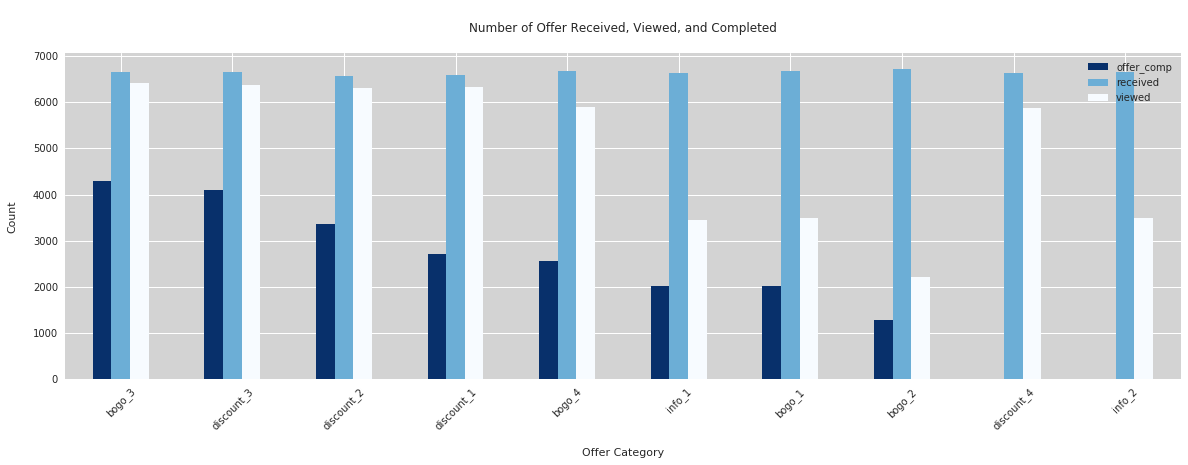

In [172]:
# compare completion, received, and viewed
offer_group = offer_new.groupby('offer_cat')[['offer_comp', 'received', 'viewed']].sum()
offer_group = offer_group.sort_values(by='offer_comp', ascending=False)
color_map = plt.cm.get_cmap('Blues')
blue = color_map.reversed()
ax = offer_group.plot.bar(rot=45, figsize=(20,6), cmap=blue, title='\nNumber of Offer Received, Viewed, and Completed\n')
ax.set_facecolor("lightgray")
ax.set(xlabel='\nOffer Category', ylabel='Count\n');
offer_group

,offer_comp,viewed
offer_cat,,
bogo_3,0.646121,0.963169
discount_3,0.615627,0.958527
discount_2,0.510036,0.959550
discount_1,0.412407,0.959958
bogo_4,0.382164,0.882987
info_1,0.305082,0.521792
bogo_1,0.302169,0.523411
bogo_2,0.190901,0.329319
discount_4,0.000000,0.884089


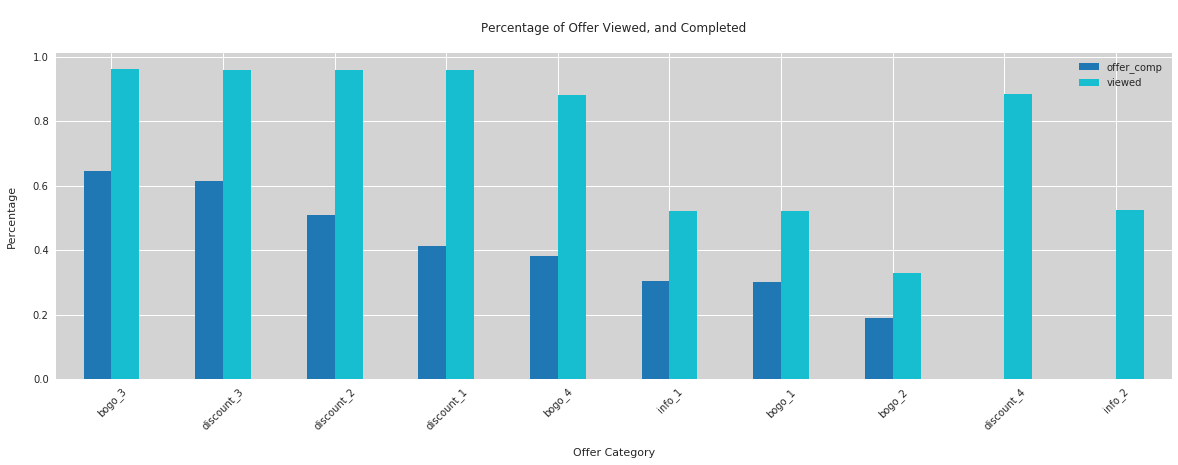

In [168]:
# create graph to compare completion rate with viewed
offer_group_percentage = offer_group.copy()
offer_group_percentage['viewed'] = offer_group_percentage['viewed'] / offer_group_percentage['received']
offer_group_percentage['offer_comp'] = offer_group_percentage['offer_comp'] / offer_group_percentage['received']
offer_group_percentage = offer_group_percentage[['offer_comp', 'viewed']]
ax = offer_group_percentage.plot.bar(rot=45, figsize=(20,6), cmap='tab10', title='\nPercentage of Offer Viewed, and Completed\n')
ax.set(xlabel='\nOffer Category', ylabel='Percentage\n')
ax.set_facecolor('lightgray');
offer_group_percentage

In [133]:
# Compare completion rate with other features. Convert everthing to a 10 base rating for ease of comparing
# Example: A $20 reward becomes $10
# Percentage: 10% = 100%
promo_dict = {'bogo_1': 1,
         'bogo_2': 2,
         'info_1': 3,
         'bogo_3': 4,
         'discount_1': 5,
         'discount_2': 6,
         'discount_3': 7,
         'info_2': 8,
         'bogo_4': 9,
         'discount_4': 10}
promotion = offer_group.copy()
promotion.reset_index(inplace=True)
promotion['offer_id'] = promotion['offer_cat'].apply(lambda x: promo_dict[x])
promotion = promotion.merge(clean_portfolio, on='offer_id')
promotion['viewed_percent'] = promotion['viewed'] / promotion['received'] * 10
promotion['comp_percent'] = promotion['offer_comp'] / promotion['received'] * 10
promotion['difficulty'] = promotion['difficulty'] / 2
promotion = promotion.sort_values(by=['comp_percent'], ascending=False)

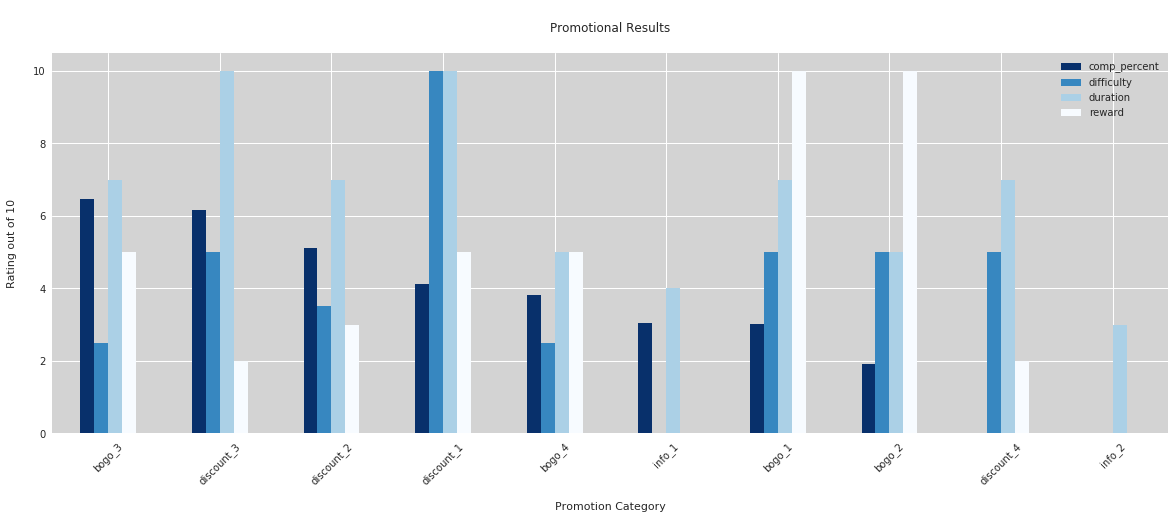

In [151]:
# create graph to compare completion rate with other offer info
ax = promotion.plot(rot=45, x='offer_cat', y=['comp_percent', 'difficulty', 'duration', 'reward'], figsize=(20,7), kind='bar', cmap=reversed_color_map, title='\nPromotional Results\n')
ax.set_xlabel('\nPromotion Category')
ax.set_ylabel('Rating out of 10\n')
ax.set_facecolor("lightgray");

In [145]:
# Analyze if promotion success has anything to do with income, age, member_length
offer_bin = offer_new.copy()
offer_bin['income_bin'] = pd.cut(offer_bin['income'], [*range(0, 140000, 10000)], labels=[*range(10000, 140000, 10000)])
offer_bin = offer_bin[['customer_id', 'offer_id', 'offer_cat', 'received', 'viewed',
       'offer_comp', 'time', 'reward_amount', 'age', 'member_since', 'gender',
       'income', 'income_bin', 'member_length', 'difficulty', 'duration', 'reward']]
offer_bin = offer_bin.groupby('offer_cat')['income', 'age', 'member_length'].mean()
offer_bin

,income,age,member_length
offer_cat,,,
bogo_1,66634.010576,54.959157,3.332243
bogo_2,67819.583029,55.429058,3.306076
bogo_3,66035.654966,54.669361,3.319068
bogo_4,66447.694108,54.518564,3.286005
discount_1,66948.127156,54.842533,3.289120
discount_2,66280.652187,54.766908,3.287304
discount_3,65714.787946,54.447210,3.287667
discount_4,64761.904762,54.220997,3.244567
info_1,67397.871733,55.130481,3.328524


In [191]:
promotion

,offer_cat,received,viewed,offer_comp,offer_id,difficulty,duration,reward,mobile,social,web,bogo,discount,informational,viewed_percent,comp_percent
2,bogo_3,6652,6407,4298,4,2.5,7,5,1,0,1,1,0,0,9.631690,6.461215
6,discount_3,6655,6379,4097,7,5.0,10,2,1,1,1,0,1,0,9.585274,6.156273
5,discount_2,6576,6310,3354,6,3.5,7,3,1,1,1,0,1,0,9.595499,5.100365
4,discount_1,6593,6329,2719,5,10.0,10,5,0,0,1,0,1,0,9.599575,4.124071
3,bogo_4,6683,5901,2554,9,2.5,5,5,1,1,1,1,0,0,8.829867,3.821637
8,info_1,6631,3460,2023,3,0.0,4,0,1,0,1,0,0,1,5.217916,3.050822
0,bogo_1,6685,3499,2020,1,5.0,7,10,1,1,0,1,0,0,5.234106,3.021690
1,bogo_2,6726,2215,1284,2,5.0,5,10,1,1,1,1,0,0,3.293191,1.909010
7,discount_4,6643,5873,0,10,5.0,7,2,1,0,1,0,1,0,8.840885,0.000000
9,info_2,6657,3487,0,8,0.0,3,0,1,1,0,0,0,1,5.238095,0.000000


In [202]:
bogo = ['bogo_1', 'bogo_2', 'bogo_3', 'bogo_4']
disc = ['discount_1', 'discount_2', 'discount_3', 'discount_4']
bogo_comp = promotion[promotion['offer_cat'].isin(bogo)]['offer_comp'].sum()
disc_comp = promotion[promotion['offer_cat'].isin(disc)]['offer_comp'].sum()
bogo_rec = promotion[promotion['offer_cat'].isin(bogo)]['received'].sum()
disc_rec = promotion[promotion['offer_cat'].isin(disc)]['received'].sum()
print('Total bogo completion: {}, Total discount completion: {}'.format(bogo_comp, disc_comp))
print('Total bogo completion rate: {:.2f}, Total discount completion rate: {:.2f}'.format((bogo_comp/bogo_rec), (disc_comp/disc_rec)))

Total bogo completion: 10156, Total discount completion: 10170
Total bogo completion rate: 0.38, Total discount completion rate: 0.38


---

## Promotion: Results <br>

- There is no correlations between the success of a promotion and income, age, or member_length
- Discount offer #4 and Information offer #2 both failed with zero completions
    - Because I don't have further information on the promotion, I could not determine why it failed
- Bogo #3 was the most successful out of all the promotions
- Overall, both Bogo and Discount promotion has about same number of completions. Bogo had 10,156 completions, while Discount had 10,170 completions. Both had a completion of 38%.
- There is no visible correlations between the success of the promotion and difficulty, duration, or reward

## Recommendation: <br>
- Because there is no correlations between Income, Age, and Member Length, it is recommended not to target a particular customer profile
- Since both promotion results are almost identical and with a completion of 38%, it is recommended to continue with both promotions. 
    - If we could find why the offer discount #4 did not get any completion, Discount promotion might have the edge, since #4 dragged down the numbers.